## PACKAGES

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import time
import dateutil.parser as parser
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## PARAMETERS

In [2]:
data_path = r"C:\Users\varun\OneDrive\Desktop\takehomeDB.db"

time_cols = ['day_of_week', 'Year', 'Hour', 'Month']
target_col = ['REQUEST_TYPE_BOOL']
location_col = ['TOWN_NAME']

## Functions and Classes

#### DATA Ingestion Functions

In [3]:
"""
    Ingest data from outside sources for ML

    This function simply ingest datasets from provided source and join them together for EDA and ML.

    Parameters
    ----------
    input : str
        outside data source path on local. 

    Returns
    -------
    dataframe
        Joined RECIEVED and REQ_INFO dataframe on common key verified as common for both dataframes.
"""
def data_ingestion(path):
    con = sqlite3.connect(path)
    ng_takehome_RECEIVED = pd.read_sql_query("SELECT * from RECEIVED", con)
    print(f'''RECEIVED dataset with calls time details {ng_takehome_RECEIVED.head()}''')
    print(f'''RECEIVED dataset number of rows, columns  {ng_takehome_RECEIVED.shape}''')
    ng_takehome_REQ_INFO = pd.read_sql_query("SELECT * from REQ_INFO", con)
    print(f'''REQ_INFO dataset with request type and location details {ng_takehome_REQ_INFO.head()}''')
    print(f'''REQ_INFO dataset number of rows, columns  {ng_takehome_REQ_INFO.shape}''')
    ng_takehome_call_data_joined = pd.read_sql_query("SELECT * from RECEIVED as rc JOIN REQ_INFO as ri ON rc.KEY = ri.KEY", con).drop('KEY', axis=1)
    print(f'''RECEIVED and REQ_INFO dateset inner joined on the common key which is dropped {ng_takehome_call_data_joined.head()}''')
    print(f'''Inner Joined dataset number of rows, columns to check if we have data for all the keys  {ng_takehome_call_data_joined.shape}''')
    return ng_takehome_call_data_joined

#### Data Pre-Processing Functions

In [4]:
"""
    Data pre-processing of raw dataframe for EDA/ML

    This function involves converting target feature which is call type into a boolean and bringing time data into useful form for EDA/ML. 
    And also cleaning for nulls and duplicates.

    Parameters
    ----------
    input : dataframe
        Dataframe with raw ingested data. 

    Returns
    -------
    dataframe
        Processed dataframe with Boolean for call type, processed time stamp data into useful features for this energy problem
        such as days_of_Week, Month, Hour and year which can all have an impact on energy usage and can lead to emergencies. 
        Also cleaned for nulls and duplicates.
"""
def data_preprocessing(raw_df):
    raw_df['REQUEST_TYPE_BOOL'] = np.nan
    raw_df['REQUEST_TYPE_BOOL'][raw_df['REQUEST_TYPE'] == 'E'] = 1
    raw_df['REQUEST_TYPE_BOOL'][raw_df['REQUEST_TYPE'] == 'N'] = 0
    print(f'''RECEIVED dataset with calls time details {raw_df.head()}''')
    print(f'''RECEIVED dataset number of rows, columns  {raw_df.shape}''')
    print(f'''Number of Emergencies or Class 1 and Normal calls or Class 0 - {raw_df['REQUEST_TYPE_BOOL'].value_counts()}''')
    raw_df['DATE_TIME_STR'] = raw_df['RECEIVED_DATE'].str.replace('00:00:00','') + raw_df['RECEIVED_TIME']
    raw_df['DATE_TIME_OBJ'] = raw_df['DATE_TIME_STR'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %I:%M:%p'))
    raw_df['Month'] = raw_df['DATE_TIME_OBJ'].dt.month
    raw_df['day_of_week'] = raw_df['DATE_TIME_OBJ'].dt.dayofweek
    raw_df['Year'] = raw_df['DATE_TIME_OBJ'].dt.year
    raw_df['Hour'] = raw_df['DATE_TIME_OBJ'].dt.hour
    raw_df['Date'] = raw_df['DATE_TIME_OBJ'].dt.date
    print(f'''Null values by columns  {raw_df.isnull().sum()}''')
    print(f'''Duplicates values by columns  {raw_df.duplicated().sum()}''')
    processed_df = raw_df.dropna().drop_duplicates()
    print(f'''Cleaned dataset after dropping any nulls and rows - number of rows, columns  {processed_df['REQUEST_TYPE_BOOL'].value_counts()}''')
    print(f'''With each representing call type - percentage Emergency Calls rows out of the total:  {processed_df['REQUEST_TYPE_BOOL'].value_counts()[1]/(processed_df['REQUEST_TYPE_BOOL'].value_counts()[0]+processed_df['REQUEST_TYPE_BOOL'].value_counts()[1])*100}''')
    return processed_df

#### Descriptive Stats Functions 

In [5]:
"""
   Processed dataframe descriptive statistics for EDA/ML

    This function involves checking for range (min, max, mean, median) of different numerics we have. Frequency of Emergency and Normal call types which 
    helps decide whether training set might need balancing for ML. Histograms of some of the key features for Normal calls and Emergency calls seperately
    to see visually where the spread lies. Also this help see features distribution types. Box plots, scatters or other chart types can also be included
    if they might help in visualizing some of the data insights better. 

    Parameters
    ----------
    input : Processed dataframe 
        Dataframe with pre-processed data. 

    Returns
    -------
    prints statistics and histograms
        Helpful descriptive statistics as described above.
"""
def data_descriptive_stats(data):
    print('Processed dataframe 5 rows overview', data.head())
    print('Range and description of numeric columns', data.describe())
    data_E = pd.DataFrame(data[data['REQUEST_TYPE']=='E']['TOWN_NAME'].value_counts()).reset_index().rename(columns = {'TOWN_NAME':'Count of Emergency Calls', 'index':'Town_Name'})
    data_N = pd.DataFrame(data[data['REQUEST_TYPE']=='N']['TOWN_NAME'].value_counts()).reset_index().rename(columns = {'TOWN_NAME':'Count of Normal Calls', 'index':'Town_Name'})
    data_by_Town = pd.merge(data_E, data_N, on = 'Town_Name')
    data_by_Town['percentage_emergencies_of_total'] = data_by_Town['Count of Emergency Calls']/(data_by_Town['Count of Emergency Calls']+data_by_Town['Count of Normal Calls'])    
    print('Number of Emergency Calls to Total Call Types Ratio by location', data_by_Town.sort_values('percentage_emergencies_of_total', ascending=False))
    plt.figure()
    n, bins, patches = plt.hist(x=data['REQUEST_TYPE'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'''REQUEST_TYPE Histogram''')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    for i in ['Month', 'day_of_week', 'Year', 'Hour', 'TOWN_NAME']:
        # An "interface" to matplotlib.axes.Axes.hist() method
        plt.figure()
        n, bins, patches = plt.hist(x=data[data['REQUEST_TYPE']=='E'][i], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel(i)
        plt.ylabel('Frequency')
        plt.title(f'''Emergency Calls {i} Histogram''')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    for j in ['Month', 'day_of_week', 'Year', 'Hour', 'TOWN_NAME']:
        # An "interface" to matplotlib.axes.Axes.hist() method
        plt.figure()
        n, bins, patches = plt.hist(x=data[data['REQUEST_TYPE']=='N'][j], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel(j)
        plt.ylabel('Frequency')
        plt.title(f'''Normal Calls {j} Histogram''')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)    

In [6]:
"""
   Correlation Checks and Heatmaps

    This function involves Target feature, Request_Type_Bool (Boolean) correlation with time and location features. 
    Biserial correlation is also tested as we have bool and integers. Heat map chart for correlation between one hot encoded columns will be too large to 
    utilize due to high cardinality.

    Parameters
    ----------
    input : Processed dataframe 
        Dataframe with pre-processed data. 

    Returns
    -------
    prints correlations and heatmap
       Correlation between features and between feature and target will help in understanding which feature will be important in ML model
       and do we have multi-collinearity.
"""
def correlation_checks(df):
    print('Call types correlation with time columns -', df.corr().sort_values('REQUEST_TYPE_BOOL'))
    for k in ['Month', 'day_of_week', 'Year', 'Hour']:
        print('Biserial correlation between Boolean Request Type and', k, '-', stats.pointbiserialr(df['REQUEST_TYPE_BOOL'], df[k])[0])
    for j in ['Month', 'day_of_week', 'Year', 'Hour']:
        print('pearsonr correlation between Boolean Request Type and', j, '-', stats.pearsonr(df['REQUEST_TYPE_BOOL'], df[j])[0])
    plt.figure(figsize=(16, 6))
    heatmap_timecol = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
    heatmap_timecol.set_title('Correlation Heatmap of call types and time columns', fontdict={'fontsize':12}, pad=12)
    print('Call types correlation with location columns -', pd.get_dummies(df[['REQUEST_TYPE_BOOL', 'TOWN_NAME']]).corr()['REQUEST_TYPE_BOOL'].sort_values(ascending=False))

#### Feature Engineering  Functions

In [7]:
"""
   Feature Engineering Approach 1 for ML

    This function involves converting categorical columns into One Hot Encoded columns, Scaling of numerics and generating ML ready
    dataframes which can be consumed by common ML algorithms.  

    Parameters
    ----------
    input : Processed dataframe 
        Dataframe with pre-processed data. 

    Returns
    -------
    target dataframe y, features dataframe X and combined dataframe including target and features.
        These ml ready dataframes are ready to be fed into multiple alogithms for model selection purposes and final model training.
"""
def feature_engineering_approach_1(data):
    location_col_df = pd.get_dummies(data[location_col]).reset_index().drop('index', axis = 1)
    print(f'''Cardinality of categorical One Hot Encoded columns - {location_col_df.shape}''')
    time_cols_df = data[time_cols].reset_index().drop('index', axis = 1)
    scaler = MinMaxScaler()
    time_cols_scaled_df = pd.DataFrame(scaler.fit_transform(time_cols_df), columns = time_cols_df.columns)
    target_df = data[target_col].reset_index().drop('index', axis = 1)
    features_df = pd.concat([time_cols_scaled_df, location_col_df], axis = 1)
    ML_ready_df = pd.concat([time_cols_scaled_df, location_col_df, target_df], axis = 1)
    return target_df, features_df, ML_ready_df

In [8]:
"""
   Feature Engineering Approach 2 for ML

    This function is same as approach 1 function except that it does not convert categorical columns into One Hot Encoded columns. This is usable by 
    alogithms such as cat boost who convert categorical columns into different encodings based on it's own optimization process and this 
    approach is recommended in their documentation. Documentation also suggest that this should lead to lower training time. 

    Parameters
    ----------
    input : Processed dataframe 
        Dataframe with pre-processed data. 

    Returns
    -------
    target dataframe y, features dataframe X and combined dataframe including target and features.
        These ml ready dataframes are ready to be fed into cat boost algorithm final model training.
"""
def feature_engineering_approach_2(data):
    location_col_df = data[location_col].reset_index().drop('index', axis = 1)
    print(f'''Cardinality of categorical One Hot Encoded columns {location_col_df.shape}''')
    time_cols_df = data[time_cols].reset_index().drop('index', axis = 1)
    scaler = MinMaxScaler()
    time_cols_scaled_df = pd.DataFrame(scaler.fit_transform(time_cols_df), columns = time_cols_df.columns)
    target_df = data[target_col].reset_index().drop('index', axis = 1)
    features_df = pd.concat([time_cols_scaled_df, location_col_df], axis = 1)
    ML_ready_df = pd.concat([time_cols_scaled_df, location_col_df, target_df], axis = 1)
    return target_df, features_df, ML_ready_df

#### Data Preparation for Machine Learning Functions

In [9]:
"""
   Train, Val and Test split of the target dataframe y, features dataframe X for ML

    This function splits target and feature dataframes for train, val and test splits to help model train without overfitting and for
    model validation. As an alternative, a cross validation approach can be considered to do a leave one year out validation (example train on 
    2011-2014 and test on 2015 and likewise) as it is closely aligned with our objective to be able to predict emergencies in the upcoming 12 months 
    or next year. We can try that to see if it may give better results by developing another model.

    Parameters
    ----------
    input : target dataframe y, features dataframe X  

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
        These dataframes are ready to be fed into all ML algorithms.
"""
def train_val_test_split(y, X):
    X_train_plus_val, X_test, y_train_plus_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train_plus_val, y_train_plus_val, test_size=0.25, random_state=1)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
"""
   Skewed Train, Val dataframes are balanced

    This function balances train or validation dataframes to solve the problem of imbalancing in the training dataset. 
    It is achieved by undersampling minority class. 
    Parameters
    ----------
    input : X_train, X_val, y_train, y_val 

    Returns
    -------
    X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced 
        These dataframes will provide balanced representation of training dataset for ML.
"""
def train_val_balancing(X_df, y_df):
    df = pd.concat([X_df, y_df], axis = 1)
    df_N = df[df['REQUEST_TYPE_BOOL']==0]
    print(f'''Number of Normal calls {df_N.shape[0]}''')
    df_E = df[df['REQUEST_TYPE_BOOL']==1]
    print(f'''Number of Emergency calls {df_E.shape}''')
    df_N_sample = df_N.sample(n=df_E.shape[0])
    print(f'''Sample of Normal call rows to balance training dataset {df_N_sample.shape}''')
    df_balanced = pd.concat([df_E, df_N_sample]).sample(frac=1)
    print(f'''Balanced training dataset {df_balanced.shape}''')
    X_df_balanced = df_balanced.drop('REQUEST_TYPE_BOOL', axis = 1)
    y_df_balanced = df_balanced[['REQUEST_TYPE_BOOL']]
    return X_df_balanced, y_df_balanced

In [11]:
"""
   Skew Factor Calculation

    This function calculates skewness in the dataframe. 
    Parameters
    ----------
    input : y_train

    Returns
    -------
    skew_factor 
        Skewness in the training dataset.
"""
def calculate_skew_factor(y_train):
    skew_factor = y_train[y_train['REQUEST_TYPE_BOOL']==0].shape[0]/y_train[y_train['REQUEST_TYPE_BOOL']==1].shape[0]
    return skew_factor

#### ML Model Validation Process Functions

In [12]:
"""
   Model Performance Scores Calculation

    This function calculates model performance scores such as recall, precision, f1_score, accuracy, auc_scores and confusion matrix using y_test
    y_predictions generated using model.predict on the x_test from different ML algorithms. 
    Parameters
    ----------
    input : y_test, y_prediction, y_score

    Returns
    -------
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score
    
"""
def model_performance(y_test, y_prediction, y_score):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_prediction).ravel()
    recall = metrics.recall_score(y_test, y_prediction)
    precision = metrics.precision_score(y_test, y_prediction)
    f1_score = metrics.f1_score(y_test, y_prediction)
    accuracy = metrics.accuracy_score(y_test, y_prediction)
    auc_score = metrics.roc_auc_score(y_test, y_score)
    return tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score

#### ML Model Training Process Class and Functions

##### Model Selection Process

In [37]:
"""
   Model Selection 

    This Class is used to calculate predictions on x_test set for different ML algorithms by fitting X_train, y_train such as logistic regression, tree algorithms 
    (such as decision tree, random forest, xgboost and catboost classifiers), naive bayes, SVM and a Deep feed forward nueral net. This
    model selection helps choose which algorithms are responding best to our ML training dataset.
    Parameters
    ----------
    input : X_train, y_train, X_test

    Returns
    -------
    y_predictions, y_score for above mentioned algorithms
    
"""
class ModelSelection:
    def __init__(self, X_train, y_train, X_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
    
    def logistic_reg(self):
        trained_model = LogisticRegression(random_state=0).fit(self.X_train, self.y_train)
        y_score = trained_model.predict_proba(self.X_test)[:, 1]
        y_predictions = trained_model.predict(self.X_test)
        return y_predictions, y_score

    def decisiontree_classifier(self):
        trained_model = DecisionTreeClassifier()
        trained_model = trained_model.fit(self.X_train,self.y_train)
        y_predictions = trained_model.predict(self.X_test)
        y_score = y_predictions
        return y_predictions, y_score

    def randomforest_classifier(self):
        trained_model=RandomForestClassifier(n_estimators=100)
        trained_model = trained_model.fit(self.X_train,self.y_train)
        y_predictions = trained_model.predict(self.X_test)
        y_score = y_predictions
        return y_predictions, y_score
    
    def catboost_classifier(self):
        trained_model = cb.CatBoostClassifier()
        trained_model = trained_model.fit(self.X_train,self.y_train, verbose = False)
        y_score = trained_model.predict_proba(self.X_test)[:, 1]
        y_predictions = trained_model.predict(self.X_test)
        return y_predictions, y_score
    
    def xgboost_classifier(self):
        trained_model = xgb.XGBClassifier()
        trained_model = trained_model.fit(self.X_train,self.y_train)
        y_score = trained_model.predict_proba(self.X_test)[:, 1]
        y_predictions = trained_model.predict(self.X_test)
        return y_predictions, y_score
    
    def naive_bayes(self):
        trained_model = GaussianNB()
        trained_model = trained_model.fit(self.X_train,self.y_train)
        y_predictions = trained_model.predict(self.X_test)
        y_score = y_predictions
        return y_predictions, y_score
    
    def svm_linear(self):
        trained_model = svm.SVC(kernel='linear')
        trained_model = trained_model.fit(self.X_train,self.y_train)
        y_predictions = trained_model.predict(self.X_test)
        y_score = y_predictions
        return y_predictions, y_score
    
    def deep_nueral_net(self):
        inputs = tf.keras.Input(shape=(self.X_train.shape[1],))
        x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(inputs)
        outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)
        trained_model = tf.keras.Model(inputs=inputs, outputs=outputs)
        trained_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        trained_model.fit(self.X_train,pd.get_dummies(self.y_train['REQUEST_TYPE_BOOL']), epochs = 10, validation_split = 0.1)
        y_pred = trained_model.predict(self.X_test)
        y_predictions = np.argmax(y_pred, axis=1)
        y_score = y_predictions
        return y_predictions, y_score

In [14]:
"""
   ML models performance claculation

    This function is a driver function used to Instantiate ModelSelection Class and it's methods to calculate performance 
    for different ML algorithms by fitting X_train, y_train such as logistic regression, tree algorithms 
    (such as decision tree, random forest, xgboost and catboost classifiers), naive bayes, SVM and a Deep feed forward nueral net. These
    model performance scores helps choose which algorithms is responding best to our ML training dataset.
    Parameters
    ----------
    input : X_train, y_train, X_test, y_test

    Returns
    -------
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score for above mentioned algorithms
    
"""
def model_selection(X_train, y_train, X_test, y_test):
    model_selection = ModelSelection(X_train, y_train, X_test)
    y_prediction, y_score = model_selection.logistic_reg()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('logistic regression performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.decisiontree_classifier()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('decisiontree performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.randomforest_classifier()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('randomforest performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.xgboost_classifier()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('xgboost performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.catboost_classifier()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('catboost performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.naive_bayes()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('naive_bayes performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    #y_prediction, y_score = model_selection.svm_linear()
    #tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    #print('svm_linear performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)
    y_prediction, y_score = model_selection.deep_nueral_net()
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    print('deep nueral net performance recall -', recall, 'precision -', precision, 'f1_score -', f1_score)

##### Hyperparameter Tuning

In [15]:
 """
   Best Model Catboost Hyperparameter Tuning approach 1

    This function is to tune hyperparameters of a catboost model which is chosen as the best model for the training dataset based
    on model selection process using random search method optimized to maximize recall. Grid search method can also be tested in future research 
    although it may cause increase in run time. So unless grid search can increase quality significantly random search should be the preferred choice.
    Also, currently we did not deploy hyperparameter tuning as part of Model Selection but only are conducting it after choosing the best model although
    future improvement can be to make it part of the model selection process.
    Parameters
    ----------
    input : X_train, y_train

    Returns
    -------
    Hyperparameters for cat boost model
    'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 'learning_rate':learning_rate_float, best_recall
    
"""
def hyperparameter_tuning(X_train, y_train):
    trained_model = cb.CatBoostClassifier(verbose = False)
    param_dist = { "learning_rate": np.linspace(0,0.2,5), "depth": stats.randint(3, 9), "iterations": stats.randint(50, 300), "l2_leaf_reg": stats.randint(2, 10)}
    rscv = RandomizedSearchCV(trained_model , param_dist, scoring='recall', cv =5)
    rscv.fit(X_train, y_train)
    return rscv.best_params_.get('depth'), rscv.best_params_.get('iterations'), rscv.best_params_.get('l2_leaf_reg'), rscv.best_params_.get('learning_rate'), rscv.best_score_

In [16]:
"""
   'Best Model Catboost Hyperparameter Tuning approach 2' 
   corresponding to 'Feature Engineering Approach 2' function

    Same as above hyperparameter tuning function except that it does not require categorical columns to be one hot encoded. Catboost documentation
    recommends this approach to allow alogirithm to decide encodings.
    Parameters
    ----------
    input : X_train, y_train

    Returns
    -------
    Hyperparameters for cat boost model
    'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 'learning_rate':learning_rate_float, best_recall
    
"""
def hyperparameter_tuning_cat(X_train, y_train):
    trained_model = cb.CatBoostClassifier(verbose = False, cat_features = ['TOWN_NAME'])
    param_dist = { "learning_rate": np.linspace(0,0.2,5), "depth": stats.randint(3, 9), "iterations": stats.randint(50, 300), "l2_leaf_reg": stats.randint(2, 10)}
    rscv = RandomizedSearchCV(trained_model , param_dist, scoring='recall', cv =5)
    rscv.fit(X_train, y_train)
    return rscv.best_params_.get('depth'), rscv.best_params_.get('iterations'), rscv.best_params_.get('l2_leaf_reg'), rscv.best_params_.get('learning_rate'), rscv.best_score_

##### ML Model Training

In [17]:
"""
   Best Model Catboost Training approach 1

    This function is used to calculate predictions on x_test set for different ML algorithms by fitting X_train, y_train in a catboost model
    and also using hyperparameters returned by the 'Best Model Catboost Hyperparameter Tuning approach 1'.
    
    Parameters
    ----------
    input : X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, 'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 
    'learning_rate':learning_rate_float

    Returns
    -------
    prediction on test set and feature importance dataframe
        y_prediction, y_score, feature_importance_df
    
"""

def catboost_classifier_OHE(X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float):
    model = cb.CatBoostClassifier(**{'eval_metric':'Recall', 'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 'learning_rate':learning_rate_float, 'class_weights':[1,skew_factor]})
    trained_model = model.fit(X_train, y_train, eval_set = (X_val, y_val), use_best_model = True, verbose = False, plot = False)
    y_score = trained_model.predict_proba(X_test)[:, 1]
    y_prediction = trained_model.predict(X_test)
    importances = trained_model.feature_importances_
    col_names = X_test.columns.tolist()
    feature_importance_df = pd.DataFrame(data={'FEATURE_COL_NAME': col_names, 'importance': importances})
    return y_prediction, y_score, feature_importance_df

In [18]:
"""
   Best Model Catboost Training approach 2 
   corresponding to 'Best Model Catboost Hyperparameter Tuning approach 2' function

    This function is used to calculate predictions on x_test set for different ML algorithms by fitting X_train, y_train in a catboost model.
    Same as above mdoel training function except that it does not require categorical columns to be one hot encoded. Catboost documentation
    recommends this approach to allow alogirithm to decide encodings.
    Parameters
    ----------
    input : X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, 'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 
    'learning_rate':learning_rate_float

    Returns
    -------
    prediction on test set and feature importance dataframe
        y_prediction, y_score, feature_importance_df
    
"""

def catboost_classifier(X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float):
    model = cb.CatBoostClassifier(**{'eval_metric':'Recall', 'depth':depth_int, 'iterations':iterations_int,'l2_leaf_reg':l2_leaf_reg_int, 'learning_rate':learning_rate_float, 'class_weights':[1,skew_factor]})
    trained_model = model.fit(X_train, y_train, eval_set = (X_val, y_val), cat_features = ['TOWN_NAME'], use_best_model = True, verbose = False, plot = False)
    y_score = trained_model.predict_proba(X_test)[:, 1]
    y_prediction = trained_model.predict(X_test)
    importances = trained_model.feature_importances_
    col_names = X_test.columns.tolist()
    feature_importance_df = pd.DataFrame(data={'FEATURE_COL_NAME': col_names, 'importance': importances})
    return y_prediction, y_score, feature_importance_df

#### Business Validation Functions

In [19]:
"""
   Business Validation - Number of actual emergencies predicted

    This function calculates business validation of the ML output scores by calculating number of actual emergencies correctly predicted.
    Parameters
    ----------
    input : X_test, y_prediction, recall, y_test

    Returns
    -------
    test_df, test_set_emergencies, emergencies_predicted
        test_set_emergencies is the total actual emergencies in the test set and emergencies_predicted are the actual emergencies correctly
        predicted out of the total. This can be defined as the Key Performance Indicator of our model. 
    
"""
def business_validation(X_test, y_prediction, recall, y_test):
    test_df = pd.concat([X_test.reset_index().drop('index', axis = 1), pd.DataFrame(y_test).reset_index().drop('index', axis = 1) ,pd.DataFrame(y_prediction).reset_index().drop('index', axis = 1)], axis = 1).rename(columns = {0:'predictions'})
    test_set_emergencies = pd.DataFrame(test_df['REQUEST_TYPE_BOOL'].value_counts())['REQUEST_TYPE_BOOL'][1]
    emergencies_predicted = pd.DataFrame(test_df['REQUEST_TYPE_BOOL'].value_counts())['REQUEST_TYPE_BOOL'][1] * recall
    return test_df, test_set_emergencies, emergencies_predicted

#### Scenario Functions - Model Selection 

In [20]:
"""
   Scenario 1 - Look for Best Model
    This driver function calculates performance scores of different ML algorithms for Model selection with using training dataset as is without balancing 
    or fixing for imbalancing in the dataset

    ----------
    input : processed_calls_data

    Returns
    -------
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score for above mentioned algorithms for model selection purposes 
    
"""

def scenario_1_best_model(processed_calls_data):
    y, X, y_X_combined = feature_engineering_approach_1(processed_calls_data)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(y, X)
    print('class imbalance -', y_train.value_counts())
    model_selection(X_train, y_train, X_test, y_test)

In [21]:
"""
   Scenario 2 - Look for Best Model
    This driver function calculates performance scores of different ML algorithms Model development with using training dataset with balancing 
    of training data set by undersampling Normal Calls or majority class rows

    ----------
    input : processed_calls_data

    Returns
    -------
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score for above mentioned algorithms for model selection purposes 
    
"""

def scenario_2_best_model(processed_calls_data):
    y, X, y_X_combined = feature_engineering_approach_1(processed_calls_data)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(y, X)
    print('class imbalance -', y_train.value_counts())
    X_train_bal, y_train_bal = train_val_balancing(X_train, y_train)
    X_val_bal, y_val_bal = train_val_balancing(X_val, y_val)
    print('class imbalance after balancing -', y_train.value_counts())
    print('X_train_balanced shape -', X_train_bal.shape, 'y_train_balanced shape -', y_train_bal.shape, 'X_test shape -', X_test.shape)
    model_selection(X_train_bal, y_train_bal, X_test, y_test)

#### Scenario Functions - Best Model Feature Engineering Approach Selection

In [22]:
"""
   Scenario 2 Best Model Training 
   corresponding to 'Scenario 2 - Look for Best Model' and 'Featuring Engineering approach 1'
    
    This driver function calculates performance scores of the best chosen Model - Cat Boost, based on above model selection process. It uses an 
    undersampled balanced training dataset for final training as a feature engineering approach with One Hot Encoded categorical columns. 

    ----------
    input : processed_calls_data

    Returns
    -------
    recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df 
    
"""

def scenario_2_trained_model(processed_calls_data):
    y, X, y_X_combined = feature_engineering_approach_1(processed_calls_data)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(y, X)
    print('class imbalance -', y_train.value_counts())
    X_train_bal, y_train_bal = train_val_balancing(X_train, y_train)
    X_val_bal, y_val_bal = train_val_balancing(X_val, y_val)
    skew_factor = calculate_skew_factor(y_train_bal)
    depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float, best_recall = hyperparameter_tuning(X_train_bal, y_train_bal)
    y_prediction, y_score, feature_importance_df  = catboost_classifier_OHE(X_train_bal, X_val_bal, X_test, y_train_bal, y_val_bal, y_test, skew_factor, depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float)
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    test_df, test_set_emergencies, emergencies_predicted = business_validation(X_test, y_prediction, recall, y_test)
    print('recall of the model or correctly predicted emergencies out of total -', recall)
    print('precision of the model or true emergencies out of total predicted emergencies -',precision)
    print('f1_Score of the model or harmonic mean of precision and recall which shows how model will do in a cost and benefit analysis of results -',f1_score)
    print('total actual emergencies in the test set -',test_set_emergencies)
    print('total actual emergencies correctly predicted out of test set -',emergencies_predicted)
    print('skewness in the training data set as a ratio of majority and minority class -', skew_factor)
    print('Important features which demonstrated strong relationship with target or call types - ', feature_importance_df)
    return tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df

In [23]:
"""
   Scenario 2 Best Model Training With Imbalancing in Training set fixed using Class Weights Instead of Undersampling
   corresponding to 'Scenario 2 - Look for Best Model' and 'Featuring Engineering approach 1'
    
    This driver function calculates performance scores of the best chosen Model - Cat Boost as decided by model selection process. It uses an 
   original imbalanced training dataset with all the rows but uses Class Weights hyperparameter which penalizes majority class to improve recall
   of minority class in it's objective function. This approach can be chosen to udnersampling as model gets to train with entire training set instead
   of undersampled set. This approach uses One Hot Encoded categorical columns. 

    ----------
    input : processed_calls_data

    Returns
    -------
    recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df 
    
"""

def scenario_2_b_trained_model_on_imbalanced_data(processed_calls_data):
    y, X, y_X_combined = feature_engineering_approach_1(processed_calls_data)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(y, X)
    print('class imbalance -', y_train.value_counts())
    skew_factor = calculate_skew_factor(y_train)
    depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float, best_recall = hyperparameter_tuning(X_train, y_train)
    y_prediction, y_score, feature_importance_df  = catboost_classifier_OHE(X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float)
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    test_df, test_set_emergencies, emergencies_predicted = business_validation(X_test, y_prediction, recall, y_test)
    print('recall of the model or correctly predicted emergencies out of total -', recall)
    print('precision of the model or true emergencies out of total predicted emergencies -',precision)
    print('f1_Score of the model or harmonic mean of precision and recall which shows how model will do in a cost and benefit analysis of results -',f1_score)
    print('total actual emergencies in the test set -',test_set_emergencies)
    print('total actual emergencies correctly predicted out of test set -',emergencies_predicted)
    print('skewness in the training data set as a ratio of majority and minority class -', skew_factor)
    print('Important features which demonstrated strong relationship with target or call types - ', feature_importance_df)
    return tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df

In [24]:
"""
   Scenario 2 Best Model Training With Imbalancing in Training set fixed using Class Weights Instead of Undersampling
   corresponding to 'Scenario 2 - Look for Best Model' and 'Featuring Engineering approach 2'
    
    This approach does not One Hot Encoded categorical columns and let's Catboost optimize encodings. This function calculates performance scores 
    of the best chosen Model - Cat Boost as decided by model selection process. It uses an original imbalanced training dataset with all the rows 
    but uses Class Weights hyperparameter which penalizes majority class to improve recall of minority class in it's objective function. 
    This approach can be chosen to udnersampling as model gets to train with entire training set instead of undersampled set.  

    ----------
    input : processed_calls_data

    Returns
    -------
    recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df 
    
"""

def scenario_2_c_trained_model_imbalanced_data_no_OHE(processed_calls_data):
    y, X, y_X_combined = feature_engineering_approach_2(processed_calls_data)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(y, X)
    print('class imbalance -', y_train.value_counts())
    skew_factor = calculate_skew_factor(y_train)
    depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float, best_recall = hyperparameter_tuning_cat(X_train, y_train)
    y_prediction, y_score, feature_importance_df  = catboost_classifier(X_train, X_val, X_test, y_train, y_val, y_test, skew_factor, depth_int, iterations_int, l2_leaf_reg_int, learning_rate_float)
    tn, fp, fn, tp, recall, precision, f1_score, accuracy, auc_score = model_performance(y_test, y_prediction, y_score)
    test_df, test_set_emergencies, emergencies_predicted = business_validation(X_test, y_prediction, recall, y_test)
    print('recall of the model or correctly predicted emergencies out of total -', recall)
    print('precision of the model or true emergencies out of total predicted emergencies -',precision)
    print('f1_Score of the model or harmonic mean of precision and recall which shows how model will do in a cost and benefit analysis of results -',f1_score)
    print('total actual emergencies in the test set -',test_set_emergencies)
    print('total actual emergencies correctly predicted out of test set -',emergencies_predicted)
    print('skewness in the training data set as a ratio of majority and minority class -', skew_factor)
    print('Important features which demonstrated strong relationship with target or call types - ', feature_importance_df)
    return tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df

## Driver Scripts

#### Run Exploratory Data Analysis

In [25]:
"""
   Run_Exploratory Data Analysis
    
    This function triggers all the exploratory analysis functions. This can be triggered to re conduct the proof of concept. 

    ----------
    input : data_path

    Returns
    -------
    Prints various exploratory analysis charts, correlation checks and insights to help understand the available data.  
    
"""
def Run_EDA(data_path):
    print('Beginning Data Ingestion Process')
    raw_calls_data = data_ingestion(data_path)
    print('Beginning Data Pre-Processing Process')
    processed_calls_data = data_preprocessing(raw_calls_data)
    print('Beginning Data Descriptive Statistics Estimation Process')
    data_descriptive_stats(processed_calls_data)
    print('Beginning Correlation Estimation Process')
    correlation_checks(processed_calls_data)
    return processed_calls_data

#### Model Selection Scenarios Runs

In [26]:
"""
   Runs Model Selection process
    
    This function triggers all the model selection scenrios to choose the best model and data feature engineering approach.
    .This can be triggered to re conduct the proof of concept.

    ----------
    input : processed_calls_data

    Returns
    -------
    prints various exploratory analysis charts, correlation checks and insights to help understand the available data.  
    
"""
def model_selection_scenario_runs(processed_calls_data):
    print('Beginning Scenario 1 - Look for Best Model Process')
    scenario_1_best_model(processed_calls_data)
    print('Beginning Scenario 2 - Look for Best Model Process')
    scenario_2_best_model(processed_calls_data)

#### Best Model Feature Engineering Scenarios Runs

In [27]:
"""
   Runs Best Model Hyperparameter Tuning and Feature Engineering Scenarios
    
    This function triggers all the hyperparameter tuning and feature engineering scenrios for the best choosen model, Cat Boost.
    . This can be triggered to re conduct the proof of concept.

    ----------
    input : processed_calls_data

    Returns
    -------
    recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df for each scenario
        This helps decide the best feature engineering scenario for final deployment. 
    
"""
def best_model_scenario_runs(processed_calls_data):
    print('Beginning Scenario 2 Best Model Training Process')
    tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df = scenario_2_trained_model(processed_calls_data)
    print('Beginning Scenario 2 Best Model Training With Imbalancing in Training set fixed using Class Weights Instead of Undersampling Process')
    tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df = scenario_2_b_trained_model_on_imbalanced_data(processed_calls_data)
    print('Beginning Scenario 2 Best Model Training With Imbalancing in Training set fixed using Class Weights Instead of Undersampling with no One Hot Encoding Process')
    tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df = scenario_2_c_trained_model_imbalanced_data_no_OHE(processed_calls_data)

#### Best Model and Feature Engineering Model Training Run via Main as Model to be Deployed

In [28]:
"""
   Main function which conducts the final training to generate the model object which can be used for production
    
    This function triggers all the finalized model functions for final deployment. The model object generated in this script can be saved as a 
    next step and can be used for inference. 

    ----------
    input : data_path

    Returns
    -------
    recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df
        Final Performance Metrics. We should conduct Model Health Monitoring on returned KPI's and performance scores. In case of statistically
        significant drift we can re-triggered the above mentioned POC scripts to choose and deploy a different model. 
    
"""
def main(data_path):
    print('Beginning Data Ingestion Process')
    raw_data = data_ingestion(data_path)
    print('Beginning Data Pre-processing Process')
    processed_data = data_preprocessing(raw_data)
    print('Beginning Data Descriptive Stats Estimation')
    data_descriptive_stats(processed_data)
    print('Beginning Correlation Estimation')
    correlation_checks(processed_data)
    print('Beginning finalized scenario run for deployment to generate performance scores.')
    tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df = scenario_2_b_trained_model_on_imbalanced_data(processed_data)
    print('recall of the model or correctly predicted emergencies out of total -', recall)
    print('precision of the model or true emergencies out of total predicted emergencies -',precision)
    print('f1_Score of the model or harmonic mean of precision and recall which shows how model will do in a cost and benefit analysis of results -',f1_score)
    print('total actual emergencies in the test set -',test_set_emergencies)
    print('total actual emergencies correctly predicted out of test set -',emergencies_predicted)
    print('skewness in the training data set as a ratio of majority and minority class -', skew_factor)
    return tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df

## For Production
#Below script with main function can be used for production deployment of the model. It can be an executable in a conda package with above functions wrapped up as utils.py which can be shared as a package with dependencies in meta.yml or whl file. 

Beginning Data Ingestion Process
RECEIVED dataset with calls time details          RECEIVED_DATE RECEIVED_TIME                  KEY
0  2011-12-01 00:00:00      06:12:AM  6123924566510169481
1  2011-12-01 00:00:00      06:40:AM  6550143904606045348
2  2011-12-01 00:00:00      07:02:AM  4924598222457909414
3  2011-12-01 00:00:00      07:28:AM  2765111898258395044
4  2011-12-01 00:00:00      07:51:AM  1361189980347937825
RECEIVED dataset number of rows, columns  (529769, 3)
REQ_INFO dataset with request type and location details   REQUEST_TYPE     TOWN_NAME                  KEY
0            E     BROOKLINE  6123924566510169481
1            N     BROOKLINE  6550143904606045348
2            E    DORCHESTER  4924598222457909414
3            E    DORCHESTER  2765111898258395044
4            N  WEST ROXBURY  1361189980347937825
REQ_INFO dataset number of rows, columns  (529769, 3)
RECEIVED and REQ_INFO dateset inner joined on the common key which is dropped          RECEIVED_DATE RECEIVED_TIME

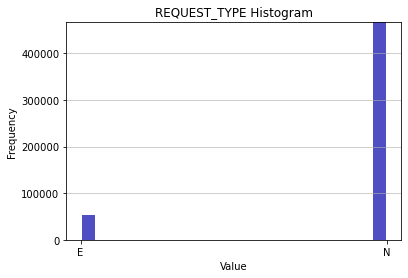

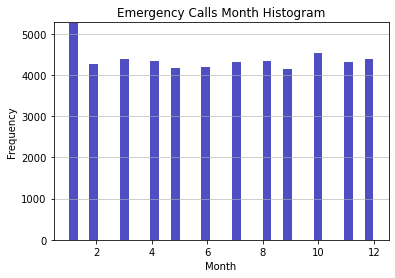

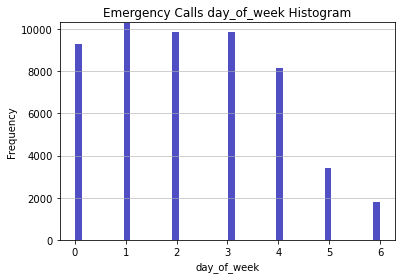

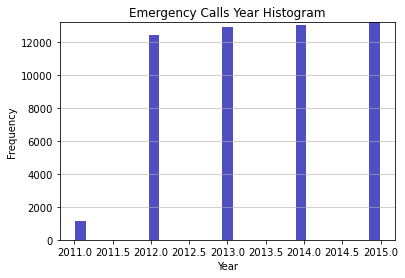

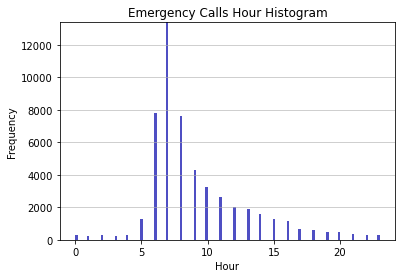

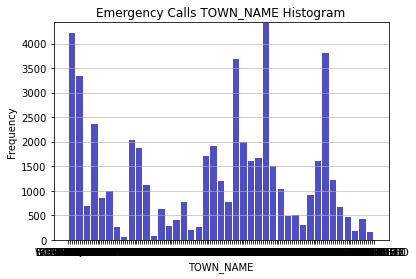

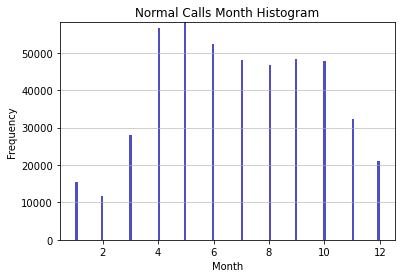

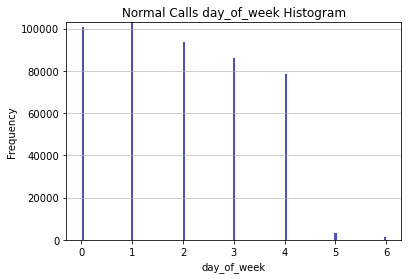

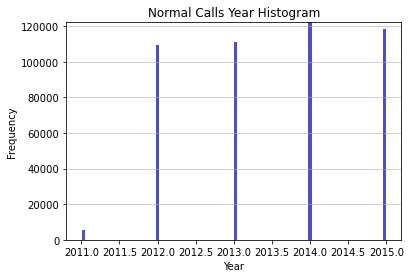

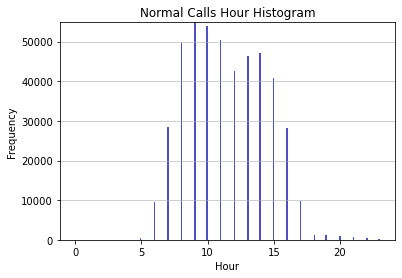

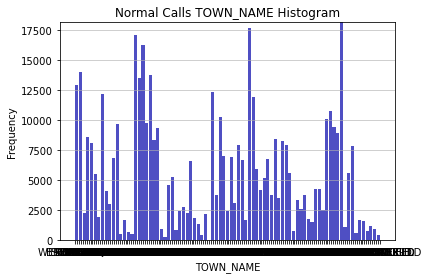

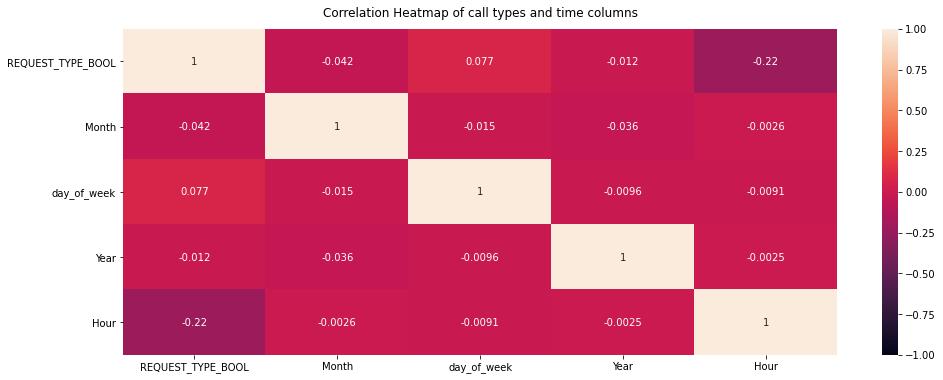

In [29]:
if __name__ == "__main__":
    tn, fp, fn, tp, recall, precision, f1_score, test_df, test_set_emergencies, emergencies_predicted, skew_factor, feature_importance_df = main(data_path)

## For Re-conducting POC (Proof of Concept)
Below functions can be triggered through seperate scripts to just run EDA, or scenarios. 

Beginning Data Ingestion Process
RECEIVED dataset with calls time details          RECEIVED_DATE RECEIVED_TIME                  KEY
0  2011-12-01 00:00:00      06:12:AM  6123924566510169481
1  2011-12-01 00:00:00      06:40:AM  6550143904606045348
2  2011-12-01 00:00:00      07:02:AM  4924598222457909414
3  2011-12-01 00:00:00      07:28:AM  2765111898258395044
4  2011-12-01 00:00:00      07:51:AM  1361189980347937825
RECEIVED dataset number of rows, columns  (529769, 3)
REQ_INFO dataset with request type and location details   REQUEST_TYPE     TOWN_NAME                  KEY
0            E     BROOKLINE  6123924566510169481
1            N     BROOKLINE  6550143904606045348
2            E    DORCHESTER  4924598222457909414
3            E    DORCHESTER  2765111898258395044
4            N  WEST ROXBURY  1361189980347937825
REQ_INFO dataset number of rows, columns  (529769, 3)
RECEIVED and REQ_INFO dateset inner joined on the common key which is dropped          RECEIVED_DATE RECEIVED_TIME

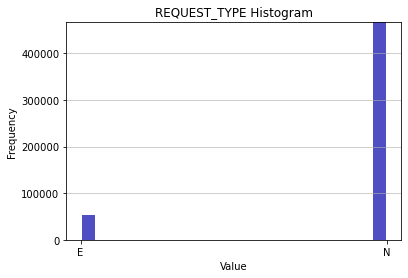

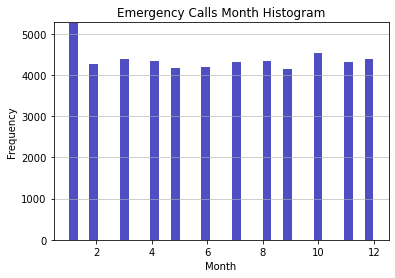

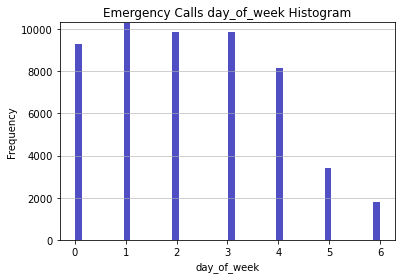

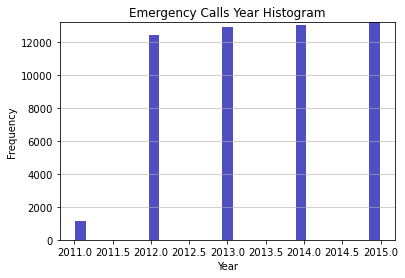

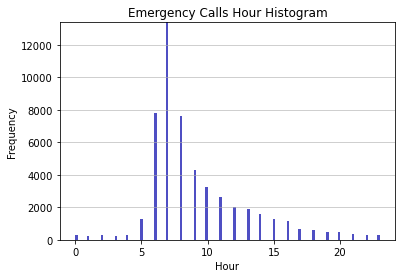

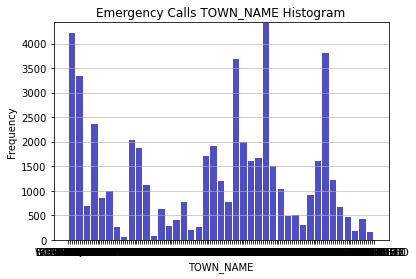

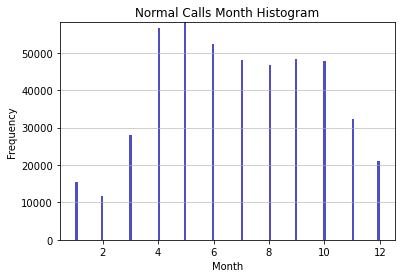

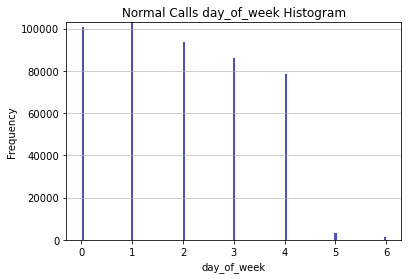

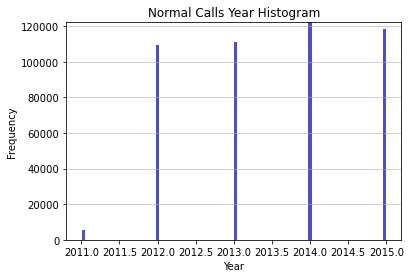

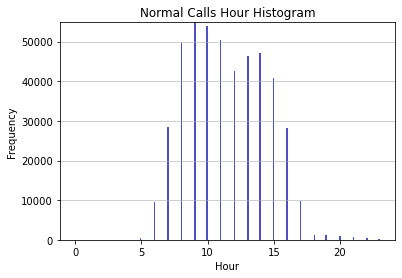

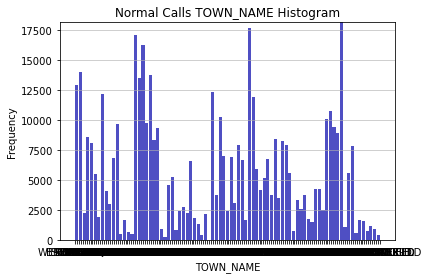

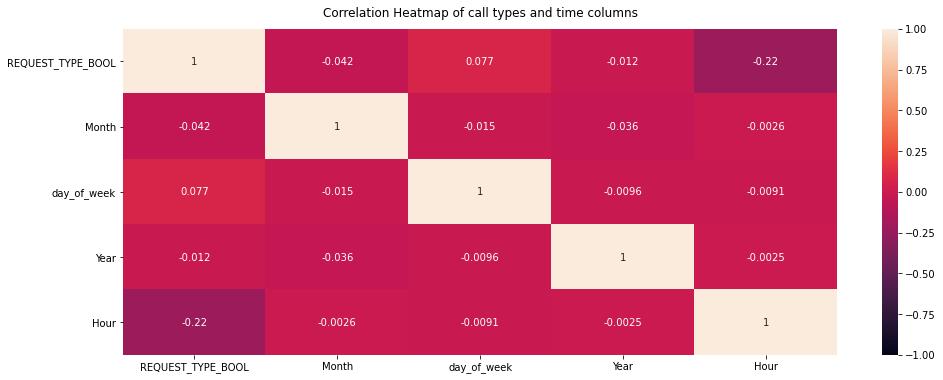

In [30]:
processed_calls_data = Run_EDA(data_path)

In [38]:
model_selection_scenario_runs(processed_calls_data)

Beginning Scenario 1 - Look for Best Model Process
Cardinality of categorical One Hot Encoded columns - (519512, 158)
class imbalance - REQUEST_TYPE_BOOL
0.0                  280181
1.0                   31525
dtype: int64
logistic regression performance recall - 0.03362914525922466 precision - 0.8275862068965517 f1_score - 0.06463195691202872
decisiontree performance recall - 0.3574964969640355 precision - 0.48394031360647444 f1_score - 0.4112179659377855
randomforest performance recall - 0.3658103689864549 precision - 0.5572790664579479 f1_score - 0.4416873449131513
[09:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost performance recall - 0.28267164876226064 precision - 0.7150283553875236 f1_score - 0.40516837383678117
catb

In [39]:
best_model_scenario_runs(processed_calls_data)

Beginning Scenario 2 Best Model Training Process
Cardinality of categorical One Hot Encoded columns - (519512, 158)
class imbalance - REQUEST_TYPE_BOOL
0.0                  280181
1.0                   31525
dtype: int64
Number of Normal calls 280181
Number of Emergency calls (31525, 163)
Sample of Normal call rows to balance training dataset (31525, 163)
Balanced training dataset (63050, 163)
Number of Normal calls 93449
Number of Emergency calls (10454, 163)
Sample of Normal call rows to balance training dataset (10454, 163)
Balanced training dataset (20908, 163)
recall of the model or correctly predicted emergencies out of total - 0.7369453526389538
precision of the model or true emergencies out of total predicted emergencies - 0.2525449772712722
f1_Score of the model or harmonic mean of precision and recall which shows how model will do in a cost and benefit analysis of results - 0.37617719285697254
total actual emergencies in the test set - 10705
total actual emergencies correctly